In [85]:
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-bigquery
# !pip install --upgrade google-cloud-storage
# !pip install db-dtypes
# !pip install 'google-cloud-bigquery[pandas]'
# !pip install numpy
# !pip install pandas
# !pip install google.cloud
# !pip install scipy
# !pip install plotly
# !pip install seaborn
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 11.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [193]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes

def test(start_date, end_date,entity_d):

    query = f"""
            select  session_key
                    ,(case when sum(case when (eventAction = 'shop.clicked') or (eventAction = 'shop_details.loaded') then 1 else 0 end) > 0 Then 1 else 0 end) as vendor_page_opened
                    ,(case when sum(case when eventAction = 'transaction' then 1 else 0 end) > 0 Then 1 else 0 end) as transacted
                    ,AVG(
    ROUND(
        COALESCE(
            CAST(
                NULLIF(
                    REGEXP_EXTRACT(
                        COALESCE(
                            json_value(eventVariables_json, "$.vendorDeliveryFee"),
                            json_value(eventVariables_json, "$.shopDeliveryFee")
                        ), 
                        r'([0-9]+\.?[0-9]*)'
                    ), 
                    ''
                ) AS FLOAT64
            ),
            0
        ),
    0)
) AS delivery_fee
                ,AVG(CAST(REGEXP_EXTRACT(json_value(eventVariables_json, "$.shopDeliveryTime"), r'\b(\d+)\b') AS INT64)) delivery_time

            FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
            WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                    AND global_entity_id = 'MJM_AT'
                    --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
            group by 1
        """
    
    return query


# def test(start_date, end_date,entity_d):

#     query = f"""
#             select  
#                     AVG(
#                             ROUND(
#                                 COALESCE(
#                                     CAST(
#                                         NULLIF(
#                                             REGEXP_EXTRACT(
#                                                 COALESCE(
#                                                     json_value(eventVariables_json, "$.vendorDeliveryFee"),
#                                                     json_value(eventVariables_json, "$.shopDeliveryFee")
#                                                 ), 
#                                                 r'([0-9]+\.?[0-9]*)'
#                                             ), 
#                                             ''
#                                         ) AS FLOAT64
#                                     ),
#                                     0
#                                 ),
#                             0)
#                         ) AS delivery_fee
#                     ,(case when sum(case when (eventAction = 'shop.clicked') or (eventAction = 'shop_details.loaded') then 1 else 0 end) > 0 Then 1 else 0 end) as vendor_page_opened
#                     ,(case when sum(case when eventAction = 'transaction' then 1 else 0 end) > 0 Then 1 else 0 end) as transacted
                    
#             FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#             WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#                     AND global_entity_id = 'MJM_AT'
#                     --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
#             group by 1
#         """
    
#     return query




<>:38: SyntaxWarning: invalid escape sequence '\.'
<>:38: SyntaxWarning: invalid escape sequence '\.'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_43414/1523187537.py:38: SyntaxWarning: invalid escape sequence '\.'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"


In [194]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

start_date = '2024-06-01'
end_date = '2024-06-07'

# entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
# 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

entity_id = 'MJM_AT'
entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

match_details_df = client.query(test(start_date, end_date,entity_id_str)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [198]:
match_details_df[~match_details_df['delivery_time'].isna()]

,session_key,vendor_page_opened,transacted,delivery_fee,delivery_time


In [71]:
match_details_df

,session_key,vendor_page_opened,transacted,delivery_fee
0,RbSwBYjOWhq9gW4NFT2GLA==,0,0,0.000000
1,jzx2bt/2fpFZPP5g48t28g==,0,0,0.000000
2,rtayWF+Bl5/y9tlASZJiRQ==,0,0,0.000000
3,0JuHcOdnqV7LuTFZGmjqSw==,0,0,0.000000
4,DXtb+0bJpoN6+LjK2rEyOw==,0,1,0.254717
...,...,...,...,...
1085347,zv4QTltygtKJuefBVrkH5Q==,1,0,0.061538
1085348,rnhCjRxUQwu7NteGYIAD8g==,1,0,0.000000
1085349,dwtPkEsd9w7ssF9IrJ0lJw==,1,0,1.500000
1085350,yeZkT2UDfkWXQiqtx2jy6A==,1,0,0.000000


In [72]:
(62666/1085352) * 100

5.773795045294062

<Axes: xlabel='delivery_fee_rounded'>

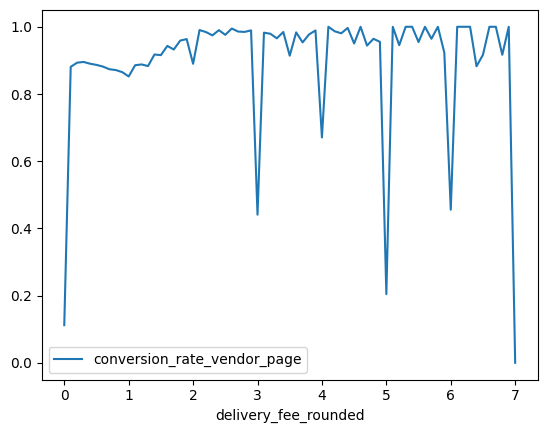

In [203]:
match_details_df['delivery_fee_rounded'] = match_details_df['delivery_fee'].round(1)
match_details_df

# Group by 'Group'
grouped = match_details_df.groupby('delivery_fee_rounded')

# Count the number of rows with value 1 in 'Value' column for each group
count_ones_v = grouped['vendor_page_opened'].apply(lambda x: (x == 1).sum())
count_ones_o = grouped['transacted'].apply(lambda x: (x == 1).sum())

# Count the total number of rows for each group
total_counts = grouped.size()

# Combine counts into a single DataFrame
result = pd.DataFrame({
    'converted_vendors': count_ones_v,
    'converted_orders': count_ones_o,
    'total_sessions': total_counts
}).reset_index()

result['conversion_rate_vendor_page'] = result['converted_vendors']/result['total_sessions']
result['conversion_rate_orders'] = result['converted_orders']/result['total_sessions']


result.plot(x = 'delivery_fee_rounded',y = 'conversion_rate_vendor_page')

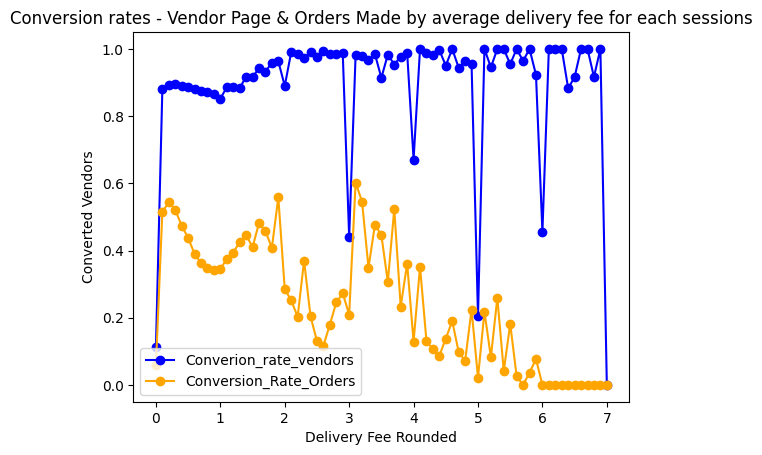

In [204]:
# Create the plot
ax = result.plot(x='delivery_fee_rounded', y='conversion_rate_vendor_page', label='Converion_rate_vendors', marker='o', color='blue')

# Plot the normalized conversion rate orders on the same axis
result.plot(x='delivery_fee_rounded', y='conversion_rate_orders', label='Conversion_Rate_Orders', marker='o', color='orange', ax=ax)

# Add labels and title
ax.set_xlabel('Delivery Fee Rounded')
ax.set_ylabel('Converted Vendors')
plt.title('Conversion rates - Vendor Page & Orders Made by average delivery fee for each sessions')

# Add a legend to distinguish between the two lines
plt.legend()

# Show the plot
plt.show()

In [205]:
result

,delivery_fee_rounded,converted_vendors,converted_orders,total_sessions,conversion_rate_vendor_page,conversion_rate_orders
0,0.0,66141,34911,591127,0.111890,0.059058
1,0.1,94235,55125,106979,0.880874,0.515288
2,0.2,77828,47346,87136,0.893178,0.543358
3,0.3,56664,32978,63290,0.895307,0.521062
4,0.4,41073,21862,46143,0.890124,0.473788
...,...,...,...,...,...,...
66,6.6,13,0,13,1.000000,0.000000
67,6.7,4,0,4,1.000000,0.000000
68,6.8,11,0,12,0.916667,0.000000
69,6.9,4,0,4,1.000000,0.000000


In [206]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Assume match_details_df is your dataframe with relevant data

# # Step 2: Prepare the data
# # Make sure 'transacted' is binary. Assuming it's already in binary form.
# X = result['delivery_fee_rounded']
# y = result['conversion_rate_orders']

# # Adding a constant to the model (the intercept term)
# X = sm.add_constant(X)

# # Step 3: Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 4: Train the model
# logit_model = sm.Logit(y_train, X_train)
# result_mo = logit_model.fit()

# # Step 5: Evaluate the model
# print(result_mo.summary())

# # Predict on the test set
# y_pred = result_mo.predict(X_test)
# y_pred_class = (y_pred > 0.5).astype(int)  # Convert probabilities to binary outcomes

# # Evaluation metrics
# accuracy = accuracy_score(y_test, y_pred_class)
# conf_matrix = confusion_matrix(y_test, y_pred_class)
# class_report = classification_report(y_test, y_pred_class)

# print(f"Accuracy: {accuracy:.2f}")
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(class_report)

# # Visualize the confusion matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(conf_matrix, cmap='Blues', alpha=0.7)
# plt.title('Confusion Matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.colorbar()
# plt.xticks([0, 1], ['Not Transacted', 'Transacted'])
# plt.yticks([0, 1], ['Not Transacted', 'Transacted'])

# # Annotate confusion matrix
# thresh = conf_matrix.max() / 2.
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         plt.text(j, i, format(conf_matrix[i, j], 'd'),
#                  horizontalalignment="center",
#                  color="white" if conf_matrix[i, j] > thresh else "black")

# plt.show()

                              OLS Regression Results                              
Dep. Variable:     conversion_rate_orders   R-squared:                       0.696
Model:                                OLS   Adj. R-squared:                  0.690
Method:                     Least Squares   F-statistic:                     123.5
Date:                    Tue, 13 Aug 2024   Prob (F-statistic):           1.44e-15
Time:                            15:53:30   Log-Likelihood:                 47.771
No. Observations:                      56   AIC:                            -91.54
Df Residuals:                          54   BIC:                            -87.49
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

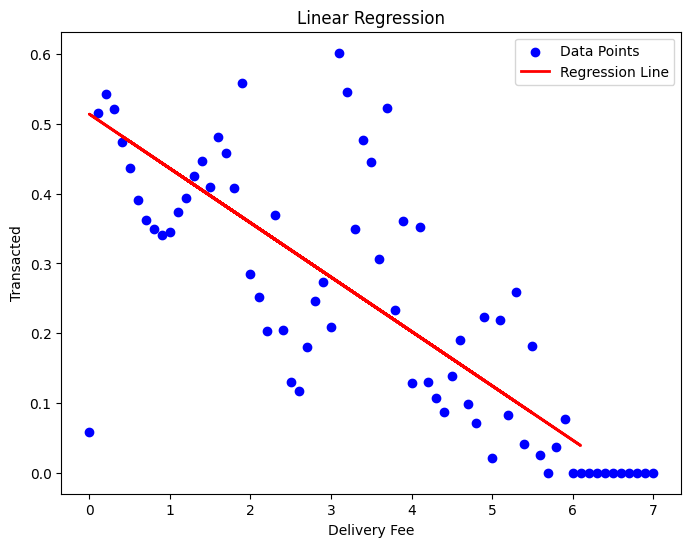

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assume match_details_df is your dataframe with relevant data

# Step 2: Prepare the data
# Extract the independent variable and dependent variable
X = result['delivery_fee_rounded']
#y = result['conversion_rate_vendor_page']
y = result['conversion_rate_orders']

# Adding a constant to the model (the intercept term)
X = sm.add_constant(X)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the model
linear_model = sm.OLS(y_train, X_train)
result_mod = linear_model.fit()

# Step 5: Evaluate the model
print(result_mod.summary())

# Predict on the test set
y_pred = result_mod.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Step 6: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X['delivery_fee_rounded'], y, color='blue', label='Data Points')
plt.plot(X_test['delivery_fee_rounded'], y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Delivery Fee')
plt.ylabel('Transacted')
plt.title('Linear Regression')
plt.legend()
plt.show()


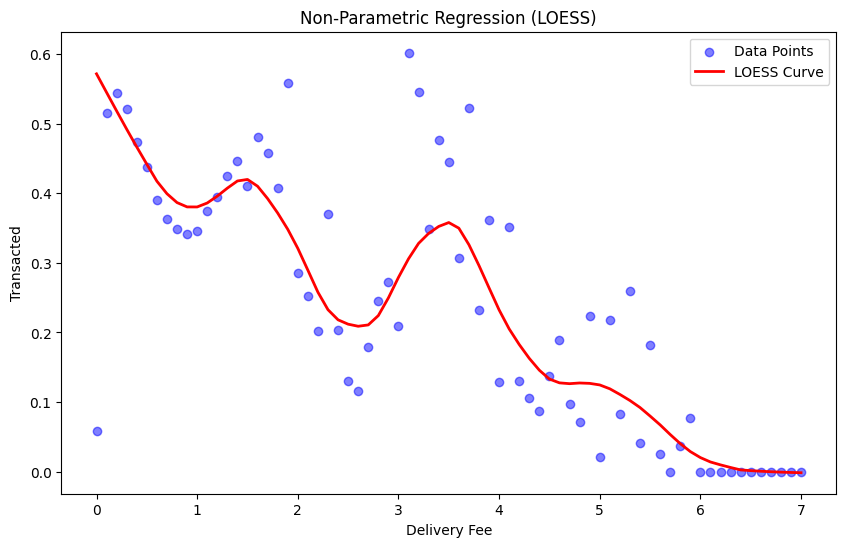

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Assume match_details_df is your dataframe with relevant data

# Step 2: Prepare the data
X = result['delivery_fee_rounded'].values
y = result['conversion_rate_orders'].values

# Step 3: Fit the model
# Using LOESS with a fraction parameter to determine the amount of smoothing
# The fraction is the proportion of the data used to estimate each y-value
loess_result = lowess(y, X, frac=0.2)  # Adjust the frac value for more or less smoothing

# Extracting the smoothed values
x_loess = loess_result[:, 0]
y_loess = loess_result[:, 1]

# Step 4: Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_loess, y_loess, color='red', linewidth=2, label='LOESS Curve')
plt.xlabel('Delivery Fee')
plt.ylabel('Transacted')
plt.title('Non-Parametric Regression (LOESS)')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     123.2
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           1.50e-15
Time:                        11:40:28   Log-Likelihood:                 47.679
No. Observations:                  56   AIC:                            -91.36
Df Residuals:                      54   BIC:                            -87.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5139      0.030     17.375      0.0

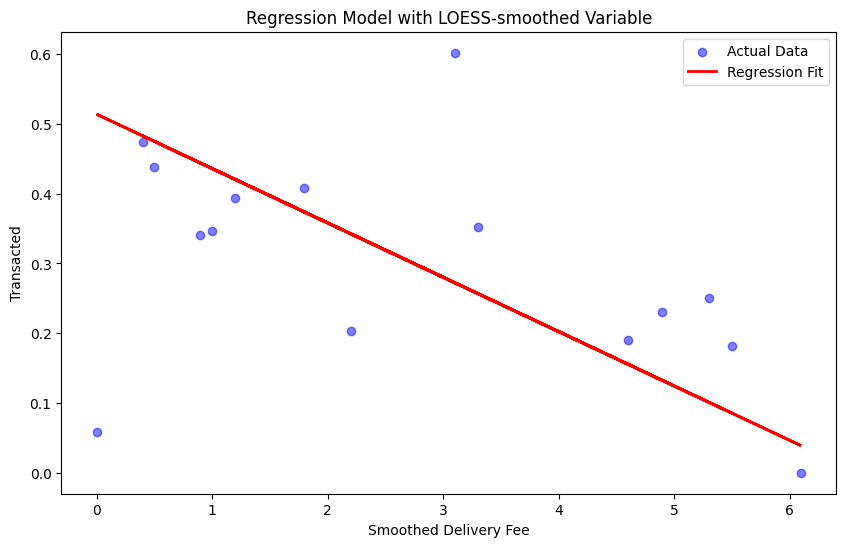

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Assume match_details_df is your dataframe with relevant data

# Extract the independent variable and the dependent variable
X = result['delivery_fee_rounded'].values
y = result['conversion_rate_orders'].values

# Step 1: Apply LOESS smoothing to the variable
loess_result = lowess(y, X, frac=0.2)  # Adjust the frac value for more or less smoothing

# Extracting the smoothed values
X_loess = loess_result[:, 0]
y_loess = loess_result[:, 1]

# Step 2: Split the data (using the smoothed variable as the new predictor)
X_train, X_test, y_train, y_test = train_test_split(X_loess, y, test_size=0.2, random_state=42)

# Adding a constant term for the intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Step 3: Fit the regression model using the smoothed variable
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Predict using the model
y_pred = results.predict(X_test_sm)

# Step 4: Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data', alpha=0.5)
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Fit')
plt.xlabel('Smoothed Delivery Fee')
plt.ylabel('Transacted')
plt.title('Regression Model with LOESS-smoothed Variable')
plt.legend()
plt.show()

In [136]:
loess_result

array([[ 0.00000000e+00,  5.71633623e-01],
       [ 1.00000000e-01,  5.44937382e-01],
       [ 2.00000000e-01,  5.18303148e-01],
       [ 3.00000000e-01,  4.92065457e-01],
       [ 4.00000000e-01,  4.66516954e-01],
       [ 5.00000000e-01,  4.41733400e-01],
       [ 6.00000000e-01,  4.17321369e-01],
       [ 7.00000000e-01,  3.99313538e-01],
       [ 8.00000000e-01,  3.86552946e-01],
       [ 9.00000000e-01,  3.80322988e-01],
       [ 1.00000000e+00,  3.80268432e-01],
       [ 1.10000000e+00,  3.85952202e-01],
       [ 1.20000000e+00,  3.95855727e-01],
       [ 1.30000000e+00,  4.07343080e-01],
       [ 1.40000000e+00,  4.17613001e-01],
       [ 1.50000000e+00,  4.19644114e-01],
       [ 1.60000000e+00,  4.09697794e-01],
       [ 1.70000000e+00,  3.91806692e-01],
       [ 1.80000000e+00,  3.71070635e-01],
       [ 1.90000000e+00,  3.47659254e-01],
       [ 2.00000000e+00,  3.20244554e-01],
       [ 2.10000000e+00,  2.88872005e-01],
       [ 2.20000000e+00,  2.57223226e-01],
       [ 2.

In [142]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Assume match_details_df is your dataframe with relevant data

# Extract the independent variable and the dependent variable
X_original = result['delivery_fee_rounded'].values
y = result['conversion_rate_vendor_page'].values

# Add a constant term for the intercept
X_original_sm = sm.add_constant(X_original)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_original_sm, y, test_size=0.2, random_state=42)

# Fit the regression model using the original variable
model_original = sm.OLS(y_train, X_train)
results_original = model_original.fit()

# Print the summary of the regression model
print("Original Variable Regression Results:")
print(results_original.summary())

Original Variable Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8417
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.363
Time:                        11:27:00   Log-Likelihood:                 14.262
No. Observations:                  56   AIC:                            -24.52
Df Residuals:                      54   BIC:                            -20.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

In [143]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Apply LOESS smoothing to the variable
loess_result = lowess(y, X_original, frac=0.2)
X_loess = loess_result[:, 0]
y_loess = loess_result[:, 1]

# Fit a regression model using the smoothed variable
X_loess_sm = sm.add_constant(X_loess)
X_train_loess, X_test_loess, y_train_loess, y_test_loess = train_test_split(X_loess_sm, y, test_size=0.2, random_state=42)

model_loess = sm.OLS(y_train_loess, X_train_loess)
results_loess = model_loess.fit()

# Print the summary of the regression model with LOESS-smoothed variable
print("LOESS-smoothed Variable Regression Results:")
print(results_loess.summary())

LOESS-smoothed Variable Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8417
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.363
Time:                        11:27:02   Log-Likelihood:                 14.262
No. Observations:                  56   AIC:                            -24.52
Df Residuals:                      54   BIC:                            -20.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   